<a href="https://colab.research.google.com/github/ItsShi/Mono-Depth/blob/main/M3depth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!rm -rf l

In [3]:
!rm -rf r

In [4]:
import torch
import sys

pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
print(version_str)
!pip -q install fvcore iopath
!pip -q install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

py37_cu113_pyt1121
     |████████████████████████████████| 50 kB 3.2 MB/s 
     |████████████████████████████████| 42 kB 888 kB/s 
     |████████████████████████████████| 47.2 MB 1.2 MB/s 


In [5]:
import pytorch3d as p3d#.iterative_closest_point

In [6]:
from pytorch3d.loss import chamfer_distance

In [7]:
import collections

def to_device(input, device):
    if torch.is_tensor(input):
        return input.to(device=device)
    elif isinstance(input, str):
        return input
    elif isinstance(input, collections.Mapping):
        return {k: to_device(sample, device=device) for k, sample in input.items()}
    elif isinstance(input, collections.Sequence):
        return [to_device(sample, device=device) for sample in input]
    else:
        raise TypeError(f"Input must contain tensor, dict or list, found {type(input)}")

##dataloader
* We need to extract images from the videos
* rectify the stereo image pairs with the given camera parameters (endoscope_calibration.yaml).
* Only keyframes were together with accurate depth maps.
* Sort the absolute image root and save them in $splits/Endovis_origin/train_files.txt.
* Change the data directory to the folder of data.

In [8]:
import gdown
gdown.download('https://drive.google.com/uc?id=1c_ewx6wts7pJTb3XVWVXEZLbFXDObpdP','SCARED',quiet=True) 
!unzip -q SCARED

# import gdown
# gdown.download('https://drive.google.com/uc?id=17k1-CHptG_XTXVX8qp7yK_zadH54vVnY',quiet=True)

In [9]:
import os
import cv2  


def video2frames(pathIn='',
                 pathOutL='',
                 pathOutR='',
                 only_output_video_info=False,
                 initial_extract_time=0,
                 end_extract_time=None,
                 extract_time_interval=-1,# default all, skip frames between time gap
                 output_prefix='frame',
                 jpg_quality=100,#0~100
                 isColor=True):
    cap = cv2.VideoCapture(pathIn) 
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  
    fps = cap.get(cv2.CAP_PROP_FPS) 
    dur = n_frames / fps 
    
    if only_output_video_info:# only info
        #print("video: {} \nDuration of the video: {} seconds \nNumber of frames: {} \nFrames per second (FPS): {}".format(pathIn, dur, n_frames, fps))
        print("video: {} \nDuration of the video: {} seconds \nNumber of frames: {} \n".format(pathIn, dur, n_frames))

    else:# 
         
        try:
            os.mkdir(pathOutR)
            os.mkdir(pathOutL)
        except OSError:
            pass
        success = True
        count = 0
        while success:
            cap.set(cv2.CAP_PROP_POS_MSEC, (1000 * initial_extract_time + count * 1000 * extract_time_interval)) #Current position of the video file in milliseconds.
            success, image = cap.read()
            if success:
                if not isColor:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                #print('Write a new frame3: {}, {}th'.format(success, count + 1))
                h, w, _ = image.shape
                l_image = image[:h//2, :, :]
                r_image = image[h//2:, :, :]
                cv2.imwrite(os.path.join(pathOutL, "{}_{:06d}.jpg".format(output_prefix, count + 1)), l_image,
                            [int(cv2.IMWRITE_JPEG_QUALITY), jpg_quality]) 
                cv2.imwrite(os.path.join(pathOutR, "{}_{:06d}.jpg".format(output_prefix, count + 1)), r_image,
                            [int(cv2.IMWRITE_JPEG_QUALITY), jpg_quality]) 
                #train_filesnames.append("/content/l/{}_{:06d}.jpg".format(output_prefix, count + 1))
                train_filesnames.append("{} {:06d}".format(output_prefix, count + 1))
                count = count + 1
        return train_filesnames

In [10]:
import matplotlib.pyplot as plt
from glob import glob
import math
path_frame_all = glob('SCARED_video/*.mp4')
print(len(path_frame_all))
 
train_filesnames = []
#total_frames = []#21893 frames in total  d7k4 28-1=27 videos / 7 videos
pathOutL = '/content/l/'
pathOutR = '/content/r/'
num_dataset = 1 #maximum 7
num_keyframe_per_set = 4 #maximum 4
for i in range(num_dataset):
  for j in range(num_keyframe_per_set):
    pathIn = "SCARED_video/d{}k{}_rgb.mp4".format(1+i,1+j)
    if pathIn =='SCARED_video/d1k4_rgb.mp4': 
      break
    video2frames(pathIn, only_output_video_info=True)
    output_prefix = 'd{}k{}'.format(1+i,1+j)
    train_files = video2frames(pathIn, pathOutL=pathOutL, pathOutR=pathOutR, output_prefix=output_prefix,extract_time_interval=1)

with open('train_filenames.txt', 'w') as f:
    for line in train_files:
        f.write(line)
        f.write('\n')

35
video: SCARED_video/d1k1_rgb.mp4 
Duration of the video: 7.88 seconds 
Number of frames: 197 

video: SCARED_video/d1k2_rgb.mp4 
Duration of the video: 11.2 seconds 
Number of frames: 280 

video: SCARED_video/d1k3_rgb.mp4 
Duration of the video: 18.84 seconds 
Number of frames: 471 



In [11]:
with open('train_filenames.txt', 'w') as f:
    for line in train_files:
        f.write(line)
        f.write('\n')
with open('val_filenames.txt', 'w') as f:
    for line in train_files:
        f.write(line)
        f.write('\n')

39
39


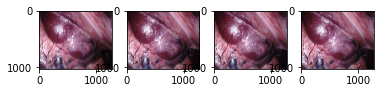

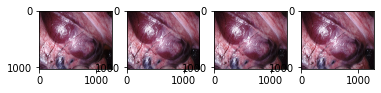

In [12]:
# from google.colab import files
# !zip -r /content/l.zip /content/l
# !zip -r /content/r.zip /content/r
# files.download('/content/l.zip')
# files.download('/content/r.zip')

path_frame_all = glob('l/*.jpg')
print(len(path_frame_all)) #saving 1 frame per second ends with 888 frames
path_frame_all = glob('r/*.jpg')
print(len(path_frame_all))
for i in range(4):
  plt.subplot(141+i), plt.imshow(plt.imread("l/d1k3_{:06d}.jpg".format(1+i)))
plt.show()
for i in range(4):
  plt.subplot(141+i), plt.imshow(plt.imread("r/d1k3_{:06d}.jpg".format(1+i)))
plt.show()

In [13]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as transforms
from PIL import Image



class ResizeImage(object):
    def __init__(self, train=True, size=(256, 512)):
        self.train = train
        self.transform = transforms.Resize(size)

    def __call__(self, sample):
        left_image = sample['left_image']
        right_image = sample['right_image']
        new_right_image = self.transform(right_image)
        new_left_image = self.transform(left_image)
        sample = {'left_image': new_left_image, 'right_image': new_right_image}

        return sample


class DoTest(object):
    def __call__(self, sample):
        '''#
        new_sample = torch.stack((sample, torch.flip(sample, [2])))
        return new_sample
        '''
        return sample


class ToTensor(object):
    def __init__(self, train):
        self.train = train
        self.transform = transforms.ToTensor()

    def __call__(self, sample):
        left_image = sample['left_image']
        right_image = sample['right_image']
        new_right_image = self.transform(right_image)
        new_left_image = self.transform(left_image)
        sample = {'left_image': new_left_image,
                  'right_image': new_right_image}
        return sample


class RandomFlip(object):
    def __init__(self, do_augmentation):
        self.transform = transforms.RandomHorizontalFlip(p=1)
        self.do_augmentation = do_augmentation

    def __call__(self, sample):
        left_image = sample['left_image']
        right_image = sample['right_image']
        k = np.random.uniform(0, 1, 1)
        if self.do_augmentation:
            if k > 0.5:
                fliped_left = self.transform(right_image)
                fliped_right = self.transform(left_image)
                sample = {'left_image': fliped_left, 'right_image': fliped_right}
        else:
            sample = {'left_image': left_image, 'right_image': right_image}
        return sample


class AugmentImagePair(object):
    def __init__(self, augment_parameters, do_augmentation):
        self.do_augmentation = do_augmentation
        self.gamma_low = augment_parameters[0]  # 0.8
        self.gamma_high = augment_parameters[1]  # 1.2
        self.brightness_low = augment_parameters[2]  # 0.5
        self.brightness_high = augment_parameters[3]  # 2.0
        self.color_low = augment_parameters[4]  # 0.8
        self.color_high = augment_parameters[5]  # 1.2

    def __call__(self, sample):
        left_image = sample['left_image']
        right_image = sample['right_image']
        p = np.random.uniform(0, 1, 1)
        if self.do_augmentation:
            if p > 0.5:
                # randomly shift gamma
                random_gamma = np.random.uniform(self.gamma_low, self.gamma_high)
                left_image_aug = left_image ** random_gamma
                right_image_aug = right_image ** random_gamma

                # randomly shift brightness
                random_brightness = np.random.uniform(self.brightness_low, self.brightness_high)
                left_image_aug = left_image_aug * random_brightness
                right_image_aug = right_image_aug * random_brightness

                # randomly shift color
                random_colors = np.random.uniform(self.color_low, self.color_high, 3)
                for i in range(3):
                    left_image_aug[i, :, :] *= random_colors[i]
                    right_image_aug[i, :, :] *= random_colors[i]

                # saturate
                left_image_aug = torch.clamp(left_image_aug, 0, 1)
                right_image_aug = torch.clamp(right_image_aug, 0, 1)

                sample = {'left_image': left_image_aug, 'right_image': right_image_aug}

        else:
            sample = {'left_image': left_image, 'right_image': right_image}
        return sample
def image_transforms(mode='train', augment_parameters=[0.8, 1.2, 0.5, 2.0, 0.8, 1.2],
                     do_augmentation=True, transformations=None,  size=(256, 512)):
    if mode == 'train':
        data_transform = transforms.Compose([
            ResizeImage(train=True, size=size),
            RandomFlip(do_augmentation),
            ToTensor(train=True),
            AugmentImagePair(augment_parameters, do_augmentation)
        ])
        return data_transform
    elif mode == 'test':
        data_transform = transforms.Compose([
            ResizeImage(train=False, size=size),
            ToTensor(train=False),
            DoTest(),
        ])
        return data_transform
    elif mode == 'custom':
        data_transform = transforms.Compose(transformations)
        return data_transform
    else:
        print('Wrong mode')

def pil_loader(path):
    # open path as file to avoid ResourceWarning
    # (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

class KittiLoader(Dataset):
    def __init__(self, root_dir, mode, filenames, transform=None):
        self.filenames = filenames
        self.loader = pil_loader
        self.img_ext = '.jpg'
        self.root_dir = root_dir
        self.side_map = {"2": 2, "3": 3, "l": 2, "r": 3}
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        line = self.filenames[idx].split()
        folder = line[0]# folder = line[0]#eg./disk_three/Dataset/Endovis_depth/Trainwith45/dataset_5/keyframe_2
        #if len(line) == 3:
        if len(line) == 2:
            frame_index = int(line[1])#eg.43
        else:
            frame_index = 0
        # line = "/disk_three/Dataset/Endovis_depth/Trainwith45/dataset_5/keyframe_2 000043 l".split()
        #l/d3k1_000001.jpg
        left_image = self.get_color(folder, frame_index, 'l')
        if self.mode == 'train':
            right_image = self.get_color(folder, frame_index, 'r')
            sample = {'left_image': left_image, 'right_image': right_image}
            if self.transform:
                sample = self.transform(sample)
                return sample
            else:
                return sample
        else:
            right_image = self.get_color(folder, frame_index, 'r')
            sample = {'left_image': left_image, 'right_image': right_image}
            if self.transform:
                if self.transform:
                    sample = self.transform(sample)
                    return sample
                else:
                    return sample

    def get_color(self, folder, frame_index, side):
        color = self.loader(self.get_image_path(folder, frame_index, side))
        return color

    def get_image_path(self, folder, frame_index, side):
        ''' For my Endovis split'''
        #l/d3k1_000001.jpg #folder:d3k1 frame_index:1 #side:l
        f_str = "{}_{:06d}{}".format(folder, frame_index, self.img_ext)
        image_path = os.path.join(side, f_str)
        '''For M3Depth'''
        # root = os.path.join(file_dir, "Data")
        # f_str = "{:06d}{}".format(frame_index, self.img_ext)
        # image_path = os.path.join(
        #     root+folder[61:], "image_0{}".format(self.side_map[side]), f_str)
        '''For the Endovis origin split'''
        # f_str = "{:06d}{}".format(frame_index, self.img_ext)#folder/image_02/000001.jpg 
        # image_path = os.path.join(
        #     folder, "image_0{}".format(self.side_map[side]), f_str)
        return image_path

def prepare_dataloader(data_directory, mode, filenames, augment_parameters,
                       do_augmentation, batch_size, size, num_workers):
    #data_dirs = os.listdir(data_directory)
    data_transform = image_transforms(
        mode=mode,
        augment_parameters=augment_parameters,
        do_augmentation=do_augmentation,
        size=size)
    datasets = [KittiLoader(data_directory, mode, filenames, transform=data_transform)]
    dataset = ConcatDataset(datasets)
    n_img = len(dataset)
    print('mode:', mode, ': Use a dataset with ', n_img, 'images')
    if mode == 'train':
        loader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=True, num_workers=num_workers,
                            pin_memory=True, drop_last=True)
    else:
        loader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=False, num_workers=num_workers,
                            pin_memory=True, drop_last=True)
    return n_img, loader

##monodepthloss, ICPloss, SSIM

In [14]:
import torch.nn as nn
class BackprojectDepth(nn.Module):
    """Layer to transform a depth image into a point cloud
    """

    def __init__(self, batch_size, height, width):
        super(BackprojectDepth, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width

        meshgrid = np.meshgrid(range(self.width), range(self.height), indexing='xy')
        self.id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
        self.id_coords = nn.Parameter(torch.from_numpy(self.id_coords),
                                      requires_grad=False)

        self.ones = nn.Parameter(torch.ones(self.batch_size, 1, self.height * self.width),
                                 requires_grad=False)

        self.pix_coords = torch.unsqueeze(torch.stack(
            [self.id_coords[0].view(-1), self.id_coords[1].view(-1)], 0), 0)
        self.pix_coords = self.pix_coords.repeat(batch_size, 1, 1)
        self.pix_coords = nn.Parameter(torch.cat([self.pix_coords, self.ones], 1),
                                       requires_grad=False)

    def forward(self, depth, inv_K):
        cam_points = torch.matmul(inv_K[:, :3, :3], self.pix_coords)
        cam_points = depth.view(self.batch_size, 1, -1) * cam_points
        cam_points = torch.cat([cam_points, self.ones], 1)

        return 

class MonodepthLoss(nn.modules.Module):
    def __init__(self, n=4, SSIM_w=0.85, disp_gradient_w=1.0, lr_w=1.0):#gradient 0.1
        super(MonodepthLoss, self).__init__()
        self.SSIM_w = SSIM_w
        self.disp_gradient_w = disp_gradient_w
        self.lr_w = lr_w
        self.n = n

    def scale_pyramid(self, img, num_scales):
        scaled_imgs = [img]
        s = img.size()
        h = s[2]
        w = s[3]
        for i in range(num_scales - 1):
            ratio = 2 ** (i + 1)
            nh = h // ratio
            nw = w // ratio
            scaled_imgs.append(nn.functional.interpolate(img,
                               size=[nh, nw], mode='bilinear',
                               align_corners=True))
        return scaled_imgs

    def gradient_x(self, img):
        # Pad input to keep output size consistent
        img = F.pad(img, (0, 1, 0, 0), mode="replicate")
        gx = img[:, :, :, :-1] - img[:, :, :, 1:]  # NCHW
        return gx

    def gradient_y(self, img):
        # Pad input to keep output size consistent
        img = F.pad(img, (0, 0, 0, 1), mode="replicate")
        gy = img[:, :, :-1, :] - img[:, :, 1:, :]  # NCHW
        return gy

    def apply_disparity(self, img, disp):
        batch_size, _, height, width = img.size()
        # Original coordinates of pixels
        x_base = torch.linspace(0, 1, width).repeat(batch_size,
                    height, 1).type_as(img)
        y_base = torch.linspace(0, 1, height).repeat(batch_size,
                    width, 1).transpose(1, 2).type_as(img)
        # Apply shift in X direction
        x_shifts = disp[:, 0, :, :]  # Disparity is passed in NCHW format with 1 channel
        flow_field = torch.stack((x_base + x_shifts, y_base), dim=3)
        # In grid_sample coordinates are assumed to be between -1 and 1
        output = F.grid_sample(img, 2*flow_field - 1, mode='bilinear',
                               padding_mode='border')

        return output

    def generate_image_left(self, img, disp):
        return self.apply_disparity(img, -disp)

    def generate_image_right(self, img, disp):
        return self.apply_disparity(img, disp)

    def SSIM(self, x, y):
        C1 = 0.01 ** 2
        C2 = 0.03 ** 2

        mu_x = nn.AvgPool2d(3, 1)(x)
        mu_y = nn.AvgPool2d(3, 1)(y)
        mu_x_mu_y = mu_x * mu_y
        mu_x_sq = mu_x.pow(2)
        mu_y_sq = mu_y.pow(2)

        sigma_x = nn.AvgPool2d(3, 1)(x * x) - mu_x_sq
        sigma_y = nn.AvgPool2d(3, 1)(y * y) - mu_y_sq
        sigma_xy = nn.AvgPool2d(3, 1)(x * y) - mu_x_mu_y

        SSIM_n = (2 * mu_x_mu_y + C1) * (2 * sigma_xy + C2)
        SSIM_d = (mu_x_sq + mu_y_sq + C1) * (sigma_x + sigma_y + C2)
        SSIM = SSIM_n / SSIM_d

        return torch.clamp((1 - SSIM) / 2, 0, 1)

    def disp_smoothness(self, disp, pyramid):
        disp_gradients_x = [self.gradient_x(d) for d in disp]
        disp_gradients_y = [self.gradient_y(d) for d in disp]

        image_gradients_x = [self.gradient_x(img) for img in pyramid]
        image_gradients_y = [self.gradient_y(img) for img in pyramid]

        weights_x = [torch.exp(-torch.mean(torch.abs(g), 1,
                     keepdim=True)) for g in image_gradients_x]
        weights_y = [torch.exp(-torch.mean(torch.abs(g), 1,
                     keepdim=True)) for g in image_gradients_y]

        smoothness_x = [disp_gradients_x[i] * weights_x[i]
                        for i in range(self.n)]
        smoothness_y = [disp_gradients_y[i] * weights_y[i]
                        for i in range(self.n)]

        return [torch.abs(smoothness_x[i]) + torch.abs(smoothness_y[i])
                for i in range(self.n)]

    def forward(self, input, target):
        """
        Args:
            input [disp1, disp2, disp3, disp4]
            target [left, right]
        Return:
            (float): The loss
        """
        left, right = target
        left_pyramid = self.scale_pyramid(left, self.n)
        right_pyramid = self.scale_pyramid(right, self.n)

        # Prepare disparities
        disp_left_est = [d[:, 0, :, :].unsqueeze(1) for d in input]
        disp_right_est = [d[:, 1, :, :].unsqueeze(1) for d in input]

        self.disp_left_est = disp_left_est
        self.disp_right_est = disp_right_est
        # Generate images
        left_est = [self.generate_image_left(right_pyramid[i],
                    disp_left_est[i]) for i in range(self.n)]
        right_est = [self.generate_image_right(left_pyramid[i],
                     disp_right_est[i]) for i in range(self.n)]
        self.left_est = left_est
        self.right_est = right_est

        # L-R Consistency
        right_left_disp = [self.generate_image_left(disp_right_est[i],
                           disp_left_est[i]) for i in range(self.n)]
        left_right_disp = [self.generate_image_right(disp_left_est[i],
                           disp_right_est[i]) for i in range(self.n)]

        # Disparities smoothness
        disp_left_smoothness = self.disp_smoothness(disp_left_est,
                                                    left_pyramid)
        disp_right_smoothness = self.disp_smoothness(disp_right_est,
                                                     right_pyramid)

        # L1
        l1_left = [torch.mean(torch.abs(left_est[i] - left_pyramid[i]))
                   for i in range(self.n)]
        l1_right = [torch.mean(torch.abs(right_est[i]
                    - right_pyramid[i])) for i in range(self.n)]

        # SSIM
        ssim_left = [torch.mean(self.SSIM(left_est[i],
                     left_pyramid[i])) for i in range(self.n)]
        ssim_right = [torch.mean(self.SSIM(right_est[i],
                      right_pyramid[i])) for i in range(self.n)]

        image_loss_left = [self.SSIM_w * ssim_left[i]
                           + (1 - self.SSIM_w) * l1_left[i]
                           for i in range(self.n)]
        image_loss_right = [self.SSIM_w * ssim_right[i]
                            + (1 - self.SSIM_w) * l1_right[i]
                            for i in range(self.n)]
        image_loss = sum(image_loss_left + image_loss_right)

        # L-R Consistency
        lr_left_loss = [torch.mean(torch.abs(right_left_disp[i]
                        - disp_left_est[i])) for i in range(self.n)]
        lr_right_loss = [torch.mean(torch.abs(left_right_disp[i]
                         - disp_right_est[i])) for i in range(self.n)]
        lr_loss = sum(lr_left_loss + lr_right_loss)

        # Disparities smoothness
        disp_left_loss = [torch.mean(torch.abs(
                          disp_left_smoothness[i])) / 2 ** i
                          for i in range(self.n)]
        disp_right_loss = [torch.mean(torch.abs(
                           disp_right_smoothness[i])) / 2 ** i
                           for i in range(self.n)]
        disp_gradient_loss = sum(disp_left_loss + disp_right_loss)

        loss = image_loss + self.disp_gradient_w * disp_gradient_loss\
               + self.lr_w * lr_loss
        self.image_loss = image_loss
        self.disp_gradient_loss = disp_gradient_loss
        self.lr_loss = lr_loss
        return loss


##### ICP #####
class ICPLoss(nn.modules.Module):
    def __init__(self, focal_length, baseline, imgWidth, imgHeight, inv_K, T, applyMask=False):
        super(ICPLoss, self).__init__()
        self.focal_length = focal_length
        self.baseline = baseline
        self.imgWidth = imgWidth
        self.imgHeight = imgHeight
        self.applyMask = applyMask
        self.inv_K = inv_K
        self.T = T
        self.MonodepthLoss = MonodepthLoss()

    def disp_to_depth(self, disp):
        depth = self.focal_length * self.baseline / (disp * self.imgWidth) # here disps should be splited
        return depth

    def apply_disparity_for_ICP(self, img, disp):    # this is from left to right ### use when apply mask
        batch_size_ICP, _, height, width = img.size()
        # Original coordinates of pixels
        x_base_ICP = torch.linspace(0, 1, width).repeat(batch_size_ICP,
                                                    height, 1).type_as(img)
        y_base_ICP = torch.linspace(0, 1, height).repeat(batch_size_ICP,
                                                     width, 1).transpose(1, 2).type_as(img)
        # Apply shift in X direction
        x_shifts_ICP = disp[:, 0, :, :]  # Disparity is passed in NCHW format with 1 channel
        flow_field_ICP = torch.stack((x_base_ICP + x_shifts_ICP, y_base_ICP), dim=3)
        # In grid_sample coordinates are assumed to be between -1 and 1
        reconstruct_image = F.grid_sample(img, 2 * flow_field_ICP - 1, mode='bilinear', padding_mode='zeros')

        return reconstruct_image

    def depth_to_pcl(self, depth, inv_K, applyMask, mask=None):
        if applyMask:
            depth = depth * (mask)
            backproject_depth = {}
            backproject_depth[0] = (BackprojectDepth(depth.shape[0], self.imgHeight, self.imgWidth)).to(device=depth.device)
            cam_points = backproject_depth[0](depth, inv_K)

        else:
            backproject_depth = {}
            backproject_depth[0] = (BackprojectDepth(depth.shape[0], self.imgHeight, self.imgWidth)).to(device=depth.device)
            cam_points = backproject_depth[0](depth, inv_K)

        return cam_points

    def compute_ICP_loss(self, pclLeft, pclRight):
        indexL = torch.randint(0, 1310720, (20000,)).cuda()
        indexR = torch.randint(0, 1310720, (20000,)).cuda()
        icploss , _ = chamfer_distance(torch.index_select(pclLeft.permute(0, 2, 1)[:, :, :3], 1, indexL),
                                       torch.index_select(pclRight.permute(0, 2, 1)[:, :, :3], 1, indexR))
        return icploss

    def compute_ICP_loss_no_MASK(self, pclLeft, pclRight):
        batchsize = pclLeft.shape[0]
        PCL_L = torch.zeros(batchsize, 3, 1000)
        PCL_R = torch.zeros(batchsize, 3, 1000)

        for item in range(batchsize):
            single_Left = pclLeft[item]
            filtered_pclLeft = single_Left[:3, :]
            single_Right = pclRight[item]
            filtered_pclRight = single_Right[:3, :]
            index = torch.randint(0, min(filtered_pclLeft.shape[1], filtered_pclRight.shape[1]), (1000,)).cuda()

            pcl_l = torch.index_select(filtered_pclLeft, 1, index)
            pcl_r = torch.index_select(filtered_pclRight, 1, index)
            # pcl_r_normal = pcl_r / max_r.unsqueeze(1)
            # PCL_L[item, :, :] = torch.matmul(self.T, pcl_l)[:3, :]
            PCL_L[item, :, :] = pcl_l
            PCL_R[item, :, :] = pcl_r

        _, icploss, _, _, _ = p3d.iterative_closest_point(PCL_L.permute(0, 2, 1),
                                                      PCL_R.permute(0, 2, 1))  # the second from last is RTs

        icploss = icploss.mean().to(pclLeft.device)
        return icploss

    def compute_ICP_loss_with_MASK(self, pclLeft, pclRight):
        batchsize = pclLeft.shape[0]
        PCL_L = torch.zeros(batchsize, 3, 1000)
        PCL_R = torch.zeros(batchsize, 3, 1000)

        for item in range(batchsize):
            single_Left = pclLeft[item]
            filtered_pclLeft = single_Left[:3, single_Left[2, :] > 0]
            single_Right = pclRight[item]
            filtered_pclRight = single_Right[:3, single_Right[2, :] > 0]
            index = torch.randint(0, min(filtered_pclLeft.shape[1], filtered_pclRight.shape[1]), (1000,)).cuda()

            pcl_l = torch.index_select(filtered_pclLeft, 1, index)
            pcl_r = torch.index_select(filtered_pclRight, 1, index)
            PCL_L[item, :, :] = pcl_l
            PCL_R[item, : ,:] = pcl_r

        _, icploss, _, _, _ = p3d.iterative_closest_point(PCL_L.permute(0, 2, 1), PCL_R.permute(0, 2, 1))  # the second from last is RTs

        icploss = icploss.mean().to(pclLeft.device)
        return icploss

    def generate_mask(self, input, target):
        """
        Args:
            input [disp1, disp2, disp3, disp4]
            target [left, right]
        Return:
            (float): The loss
        """
        left, right = target
        left_pyramid = self.MonodepthLoss.scale_pyramid(left, self.MonodepthLoss.n)
        right_pyramid = self.MonodepthLoss.scale_pyramid(right, self.MonodepthLoss.n)

        # Prepare disparities
        disp_left_est = [d[:, 0, :, :].unsqueeze(1) for d in input]
        disp_right_est = [d[:, 1, :, :].unsqueeze(1) for d in input]

        # Generate images
        reconstruct_left = [self.apply_disparity_for_ICP(right_pyramid[i],
                                             -disp_left_est[i]) for i in range(self.MonodepthLoss.n)]
        reconstruct_right = [self.apply_disparity_for_ICP(left_pyramid[i],
                                               disp_right_est[i]) for i in range(self.MonodepthLoss.n)]
        #### MASK ####
        left_mask = [(torch.where(reconstruct_left[0][:, 0, :, :] == 0, torch.tensor(0).cuda(), torch.tensor(1).cuda())).unsqueeze(1)]
        right_mask = [(torch.where(reconstruct_right[0][:, 0, :, :] == 0, torch.tensor(0).cuda(), torch.tensor(1).cuda())).unsqueeze(1)]
        left_mask = F.interpolate(left_mask[0].float(), [self.imgHeight, self.imgWidth], mode="bilinear", align_corners=False)
        right_mask = F.interpolate(right_mask[0].float(), [self.imgHeight, self.imgWidth], mode="bilinear", align_corners=False)

        return left_mask, right_mask

    def forward(self, disps, img=None):
        # ICPLossCompute
        """
        Args:
            input [disp1, disp2, disp3, disp4]
            img [left, right]
        Return:
            (float): The loss
        """
        ##### please note here only calculate for scale 0, the original input size

        disp_left = disps[0][:, 0, :, :].unsqueeze(1)
        disp_right = disps[0][:, 1, :, :].unsqueeze(1)

        if not self.applyMask:
            depth_left = F.interpolate(self.disp_to_depth(disp_left), [self.imgHeight, self.imgWidth], mode="bilinear",
                                       align_corners=False)
            depth_right = F.interpolate(self.disp_to_depth(disp_right), [self.imgHeight, self.imgWidth],
                                        mode="bilinear", align_corners=False)
            pcl_left = self.depth_to_pcl(depth_left, self.inv_K, self.applyMask)   # depth_to_pcl should be changed with more parameters
            pcl_right = self.depth_to_pcl(depth_right, self.inv_K, self.applyMask)
            ICPLoss = self.compute_ICP_loss_no_MASK(pcl_left, pcl_right)

        else:
            depth_left = F.interpolate(self.disp_to_depth(disp_left), [self.imgHeight, self.imgWidth], mode="bilinear",
                                       align_corners=False)
            depth_right = F.interpolate(self.disp_to_depth(disp_right), [self.imgHeight, self.imgWidth],
                                        mode="bilinear", align_corners=False)
            # depth_left = self.disp_to_depth(disp_left)
            # depth_right = self.disp_to_depth(disp_right)
            left_mask, right_mask = self.generate_mask(disps, img)
            pcl_left = self.depth_to_pcl(depth_left, self.inv_K, self.applyMask, left_mask)  # depth_to_pcl should be changed with more parameters
            pcl_right = self.depth_to_pcl(depth_right, self.inv_K, self.applyMask, right_mask)
            ICPLoss = self.compute_ICP_loss_with_MASK(pcl_left, pcl_right)

        return ICPLoss


##model

In [15]:
class conv(nn.Module):
    def __init__(self, num_in_layers, num_out_layers, kernel_size, stride):
        super(conv, self).__init__()
        self.kernel_size = kernel_size
        self.conv_base = nn.Conv2d(num_in_layers, num_out_layers, kernel_size=kernel_size, stride=stride)
        self.normalize = nn.BatchNorm2d(num_out_layers)

    def forward(self, x):
        p = int(np.floor((self.kernel_size-1)/2))
        p2d = (p, p, p, p)
        x = self.conv_base(F.pad(x, p2d))
        x = self.normalize(x)
        return F.elu(x, inplace=True)
class maxpool(nn.Module):
    def __init__(self, kernel_size):
        super(maxpool, self).__init__()
        self.kernel_size = kernel_size

    def forward(self, x):
        p = int(np.floor((self.kernel_size-1) / 2))
        p2d = (p, p, p, p)
        return F.max_pool2d(F.pad(x, p2d), self.kernel_size, stride=2)
class resconv_basic(nn.Module):
    # for resnet18
    def __init__(self, num_in_layers, num_out_layers, stride):
        super(resconv_basic, self).__init__()
        self.num_out_layers = num_out_layers
        self.stride = stride
        self.conv1 = conv(num_in_layers, num_out_layers, 3, stride)
        self.conv2 = conv(num_out_layers, num_out_layers, 3, 1)
        self.conv3 = nn.Conv2d(num_in_layers, num_out_layers, kernel_size=1, stride=stride)
        self.normalize = nn.BatchNorm2d(num_out_layers)

    def forward(self, x):
        #         do_proj = x.size()[1] != self.num_out_layers or self.stride == 2
        do_proj = True
        shortcut = []
        x_out = self.conv1(x)
        x_out = self.conv2(x_out)
        if do_proj:
            shortcut = self.conv3(x)
        else:
            shortcut = x
        return F.elu(self.normalize(x_out + shortcut), inplace=True)
def resblock_basic(num_in_layers, num_out_layers, num_blocks, stride):
    layers = []
    layers.append(resconv_basic(num_in_layers, num_out_layers, stride))
    for i in range(1, num_blocks):
        layers.append(resconv_basic(num_out_layers, num_out_layers, 1))
    return nn.Sequential(*layers)
class upconv(nn.Module):
    def __init__(self, num_in_layers, num_out_layers, kernel_size, scale):
        super(upconv, self).__init__()
        self.scale = scale
        self.conv1 = conv(num_in_layers, num_out_layers, kernel_size, 1)

    def forward(self, x):
        x = nn.functional.interpolate(x, scale_factor=self.scale, mode='bilinear', align_corners=True)
        return self.conv1(x)
class get_fine_disp(nn.Module):
    def __init__(self, num_in_layers):
        super(get_fine_disp, self).__init__()
        self.conv1 = nn.Conv2d(num_in_layers, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 2, kernel_size=3, stride=1, padding=1)
        self.normalize = nn.BatchNorm2d(4)
        self.relu = nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

In [16]:
class Resnet18_md(nn.Module):
    def __init__(self, num_in_layers):
        super(Resnet18_md, self).__init__()
        # encoder
        self.conv1 = conv(num_in_layers, 64, 7, 2)  # H/2  -   64D    
        self.pool1 = maxpool(3)  # H/4  -   64D   
        self.conv2 = resblock_basic(64, 64, 2, 2)  # H/8  -  64D
        self.conv3 = resblock_basic(64, 128, 2, 2)  # H/16 -  128D
        self.conv4 = resblock_basic(128, 256, 2, 2)  # H/32 - 256D
        self.conv5 = resblock_basic(256, 512, 2, 2)  # H/64 - 512D

        # decoder
        self.upconv6 = upconv(512, 512, 3, 2)
        self.iconv6 = conv(256+512, 512, 3, 1)

        self.upconv5 = upconv(512, 256, 3, 2)
        self.iconv5 = conv(128+256, 256, 3, 1)

        self.upconv4 = upconv(256, 128, 3, 2)
        self.iconv4 = conv(64+128, 128, 3, 1)
        self.disp4_layer = get_fine_disp(128)

        self.upconv3 = upconv(128, 64, 3, 2)
        self.iconv3 = conv(64+64 + 2, 64, 3, 1)
        self.disp3_layer = get_fine_disp(64)

        self.upconv2 = upconv(64, 32, 3, 2)
        self.iconv2 = conv(64+32 + 2, 32, 3, 1)
        self.disp2_layer = get_fine_disp(32)

        self.upconv1 = upconv(32, 16, 3, 2)
        self.iconv1 = conv(16+2, 16, 3, 1)
        self.disp1_layer = get_fine_disp(16)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x_pool1 = self.pool1(x1)
        x2 = self.conv2(x_pool1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)

        # skips
        skip1 = x1
        skip2 = x_pool1
        skip3 = x2
        skip4 = x3
        skip5 = x4

        # decoder
        upconv6 = self.upconv6(x5)
        concat6 = torch.cat((upconv6, skip5), 1)
        iconv6 = self.iconv6(concat6)

        upconv5 = self.upconv5(iconv6)
        concat5 = torch.cat((upconv5, skip4), 1)
        iconv5 = self.iconv5(concat5)

        upconv4 = self.upconv4(iconv5)
        concat4 = torch.cat((upconv4, skip3), 1)
        iconv4 = self.iconv4(concat4)
        self.disp4 = self.disp4_layer(iconv4)

        self.udisp4 = nn.functional.interpolate(self.disp4, scale_factor=2, mode='bilinear', align_corners=True)

        upconv3 = self.upconv3(iconv4)
        concat3 = torch.cat((upconv3, skip2, self.udisp4), 1)
        iconv3 = self.iconv3(concat3)
        self.disp3 = self.disp3_layer(iconv3)
        self.udisp3 = nn.functional.interpolate(self.disp3, scale_factor=2, mode='bilinear', align_corners=True)

        upconv2 = self.upconv2(iconv3)
        concat2 = torch.cat((upconv2, skip1, self.udisp3), 1)
        iconv2 = self.iconv2(concat2)
        self.disp2 = self.disp2_layer(iconv2)
        self.udisp2 = nn.functional.interpolate(self.disp2, scale_factor=2, mode='bilinear', align_corners=True)

        upconv1 = self.upconv1(iconv2)
        concat1 = torch.cat((upconv1, self.udisp2), 1)
        iconv1 = self.iconv1(concat1)
        self.disp1 = self.disp1_layer(iconv1)
        return self.disp1, self.disp2, self.disp3, self.disp4

In [17]:
def get_model(model, input_channels=3, pretrained=False):
    if model == 'resnet50_md':
        #out_model = Resnet50_md(input_channels)
        pass
    elif model == 'resnet18_md':
        out_model = Resnet18_md(input_channels)
    else:
        #out_model = ResnetModel(input_channels, encoder=model, pretrained=pretrained)
        pass
    return out_model

In [18]:

class Model:
    def __init__(self, args):
        self.args = args
        # create weight folder
        if os.path.isdir(args.model_path):
            print('Weights folder exists')
        else:
            print('Weights folder create')
            os.makedirs(args.model_path)

        # Set up model
        self.device = args.device
        self.model = get_model(args.model, input_channels=args.input_channels,
                               pretrained=args.pretrained)
        self.model = self.model.to(self.device)
        if args.use_multiple_gpu:
            self.model = torch.nn.DataParallel(self.model)
        if self.args.applyICP:
            # intrinsic matrix
            self.K = np.array([[1.18849248e+03, 0.00000000e+00, 6.41449814e+02, 0.00000000e+00],
                               [0.00000000e+00, 1.18849248e+03, 5.20022934e+02, 0.00000000e+00],
                               [0, 0, 1, 0],
                               [0, 0, 0, 1]], dtype=np.float32)
            self.inv_K = transforms.ToTensor()(np.linalg.pinv(self.K)).to(self.device)
            self.inv_K = self.inv_K.repeat(self.args.batch_size, 1, 1)
            # Extrinsic parameters
            self.T = np.eye(4, dtype=np.float32)
            self.T[0, 3] = -4.2  # average baseline
            self.T = torch.from_numpy(self.T).to(self.device)

        if args.mode == 'train':
            args.data_dir = os.path.join(args.data_dir, 'Train')
            self.loss_function = MonodepthLoss(
                n=4,
                SSIM_w=0.85,
                disp_gradient_w=0.1, lr_w=1).to(self.device)
            #### ICP ####
            if self.args.applyICP:
                self.ICPLossMask = ICPLoss(self.args.focal_length, self.args.baseline,
                                             self.args.full_width, self.args.full_height,
                                             self.inv_K, self.T, self.args.ICPMask)

            self.optimizer = optim.Adam(self.model.parameters(),
                                        lr=args.learning_rate)

            if args.resume is not None:
                self.load_model_continue_train(os.path.join(self.args.model_path, 'weights_last.pt'))
                self.args.startEpoch = self.startEpoch

            #fpath = os.path.join(os.path.dirname(__file__), "splits", args.split, "{}_files.txt")
            # train_filenames = readlines(fpath.format("train"))
            # val_filenames = readlines(fpath.format("val"))
            with open("train_filenames.txt", 'r') as f:
              train_filenames = f.read().splitlines()
            with open("val_filenames.txt", 'r') as f:
              val_filenames = f.read().splitlines()

            self.val_n_img, self.val_loader = prepare_dataloader(args.val_data_dir, args.mode, val_filenames,
                                                                 args.augment_parameters,
                                                                 False, args.batch_size,
                                                                 (args.input_height, args.input_width),
                                                                 args.num_workers) #aug[0.8, 1.2, 0.5, 2.0, 0.8, 1.2], do_aug=False, batch_size=25(mini default=256), (256,320),4 dataloader workers
            # Load data
            self.output_directory = args.output_directory
            self.input_height = args.input_height
            self.input_width = args.input_width
            self.n_img, self.loader = prepare_dataloader(args.data_dir, args.mode,
                                                         train_filenames,
                                                         args.augment_parameters,
                                                         args.do_augmentation, args.batch_size,
                                                         (args.input_height, args.input_width),
                                                         args.num_workers)#do_aug=True
        else:
            args.test_model_path = os.path.join(self.args.model_path, args.testepoch + '.pth')
            self.model.load_state_dict(torch.load(args.test_model_path))
            args.augment_parameters = None
            args.do_augmentation = False
            args.batch_size = 1
            if args.mode == 'test':
                args.data_dir = os.path.join(args.data_dir, 'test')

        if 'cuda' in self.device:
            torch.cuda.synchronize()

    def train(self):
        losses = []
        val_losses = []
        ICPLosses = 0.0
        best_val_loss = float('Inf')
        running_val_loss = 0.0
        self.model.eval()
        for data in self.val_loader:
            data = to_device(data, self.device)  # dict
            left = data['left_image']
            right = data['right_image']
            disps = self.model(left)
            loss = self.loss_function(disps, [left, right])
            #### ICP ####
            if self.args.applyICP:
                ICPLoss = self.args.ICPweight * self.ICPLossMask(disps, [left, right])
                loss = loss + ICPLoss
            val_losses.append(loss.item())
            running_val_loss += loss.item()

        running_val_loss /= self.val_n_img / self.args.batch_size
        print('Val_loss:', running_val_loss)

        for epoch in range(self.args.startEpoch, self.args.epochs):
            if self.args.adjust_lr:
                adjust_learning_rate(self.optimizer, epoch,
                                     self.args.learning_rate)
            c_time = time.time()
            running_loss = 0.0
            self.model.train()
            for data in self.loader:
                # Load data
                data = to_device(data, self.device)
                left = data['left_image']
                right = data['right_image']

                # One optimization iteration
                self.optimizer.zero_grad()
                disps = self.model(left)
                loss = self.loss_function(disps, [left, right])
                #### ICP####
                if self.args.applyICP:
                    ICPLoss = self.args.ICPweight * self.ICPLossMask(disps, [left, right])
                    loss = loss + ICPLoss
                loss.backward()
                self.optimizer.step()
                losses.append(loss.item())
                running_loss += loss.item()
                if self.args.applyICP:
                    ICPLosses += ICPLoss

            running_val_loss = 0.0
            self.model.eval()
            for data in self.val_loader:
                data = to_device(data, self.device)
                left = data['left_image']
                right = data['right_image']
                disps = self.model(left)
                loss = self.loss_function(disps, [left, right])
                val_losses.append(loss.item())
                running_val_loss += loss.item()

            # Estimate loss per image
            running_loss /= self.n_img / self.args.batch_size
            running_val_loss /= self.val_n_img / self.args.batch_size
            print(
                'Epoch:',
                epoch + 1,
                'train_loss:',
                running_loss,
                'val_loss:',
                running_val_loss,
                'time:',
                round(time.time() - c_time, 3),
                's',
            )
            self.save(os.path.join(self.args.model_path, 'border_last.pth'))
            self.save_continue_train(epoch, running_loss, 'weights_last.pt')
            # save weights for every epoch
            self.save(os.path.join(self.args.model_path, 'epoch{}.pth'.format(str(epoch))))
            if running_val_loss < best_val_loss:
                self.save(os.path.join(self.args.model_path, 'border_cpt.pth'))
                self.save_continue_train(epoch, running_val_loss, 'weights_cpt.pt')
                best_val_loss = running_val_loss
                print('Model_saved')

        print('Finished Training.')
        # self.save(os.path.join(self.args.model_path, 'train_end.pth'))
        self.save_continue_train(self.args.epochs, running_val_loss, 'train_end.pt')

    def save(self, path):
        torch.save(self.model.state_dict(), path)

    def save_continue_train(self, epoch, loss, path):
        save_path = os.path.join(self.args.model_path, path)
        torch.save({'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss': loss,
                    }, save_path)

    def load(self, path):
        self.model.load_state_dict(torch.load(path))

    def load_model_continue_train(self, path):
        assert os.path.isfile(path), \
            "Cannot find folder {}".format(path)
        print("loading model from folder {}".format(path))
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.startEpoch = checkpoint['epoch']

    def test(self):
        self.model.eval()

        ''' train on full endovis and test on Endovis test dataset keyframe'''
        if self.args.endovis_test_key:
            errors = []
            baseline = 4.2  # 5.045158438885819
            focal = 1135  # # 7866.0520212773545
            transform_resize = transforms.Resize((256, 320))
            with torch.no_grad():
                ground_truth_dir = '/disk_three/Dataset/Endovis_depth/TestKeyFrameOnly/depth'
                test_data_dir = '/disk_three/Dataset/Endovis_depth/TestKeyFrameOnly/image'
                image02_file = os.path.join(ground_truth_dir, 'image_02')
                image03_file = os.path.join(ground_truth_dir, 'image_03')
                for image in sorted(os.listdir(image02_file)):
                    ground_truth_image_file_left = os.path.join(image02_file, image)
                    ground_truth_image_file_right = os.path.join(image03_file, image)
                    test_RGB_image_file_left = os.path.join(test_data_dir, 'image_02', image)
                    test_RGB_image_file_right = os.path.join(test_data_dir, 'image_03', image)

                    if not os.path.exists(ground_truth_image_file_left) and os.path.exists(
                            test_RGB_image_file_left):
                        print('Error: point could not found - {}'.format(test_RGB_image_file_left))
                    ''' Load in Input image '''
                    left_input_image = pil.open(test_RGB_image_file_left).convert('RGB')
                    left_input_image = transform_resize(left_input_image)
                    right_input_image = pil.open(test_RGB_image_file_right).convert('RGB')
                    left_input_image = transforms.ToTensor()(left_input_image).unsqueeze(0)
                    right_input_image = transforms.ToTensor()(right_input_image).unsqueeze(0)
                    left_input_image = left_input_image.to(self.device)
                    right_input_image = right_input_image.to(self.device)
                    ''' Load in grond truth'''
                    depth_gt_left = pil.open(ground_truth_image_file_left).convert('L')
                    depth_gt_left = np.asarray(depth_gt_left, dtype="float32")

                    if np.sum(depth_gt_left > 0.1) < (0.1 * np.size(depth_gt_left)):
                        print('abe == -1')
                    else:
                        disps = self.model(left_input_image)
                        disps_upsample = F.interpolate(disps[0][:, 0, :, :].unsqueeze(1),
                                                       [self.args.full_height, self.args.full_width], mode="bilinear",
                                                       align_corners=False).squeeze().cpu().detach().numpy()
                        depth_pred = (baseline * focal) / (disps_upsample * 1280)

                    errors.append(compute_errors(depth_gt_left, depth_pred))
                    mean_errors = np.array(errors).mean(0)

                #### 7 criteria ####
                print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
                print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
                print("\n-> Done!")


#argumetns

In [19]:
import argparse
import time
import torch
import numpy as np
import torch.optim as optim
from skimage.io import imread, imshow
from skimage.metrics import structural_similarity as ssim
# custom modules
# from utils import get_model, to_device, prepare_dataloader, readlines
# from loss import MonodepthLoss, ICPLoss
import os
import torch.nn.functional as F
import PIL.Image as pil
from torchvision import transforms
import cv2
import matplotlib.cm as cm

# plot params

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 10) #runtime config

file_dir = os.path.dirname("content/")  # the directory that main.py resides in


def return_arguments():
    parser = argparse.ArgumentParser(description='PyTorch Monodepth')

    parser.add_argument('--data_dir',
                        type=str,
                        help='path to the dataset folder',
                        default='/disk_three/Dataset/Endovis_depth')
    parser.add_argument('--val_data_dir',
                        help='path to the validation dataset folder',
                        default='/disk_three/Dataset/Endovis_depth/Test')
    parser.add_argument('--split',
                        type=str,
                        help='splits to load data',
                        default='Endovis_origin')
    parser.add_argument('--model_path',
                        default=os.path.join(file_dir, "weights"),
                        help='path to the trained model')
    parser.add_argument('--output_directory',
                        help='where save dispairities\
                        for tested images')
    parser.add_argument('--input_height', type=int, help='input height',
                        default=256)
    parser.add_argument('--input_width', type=int, help='input width',
                        default=320)
    parser.add_argument('--full_height', type=int, help='input height',
                        default=1024)
    parser.add_argument('--full_width', type=int, help='input width',
                        default=1280)
    parser.add_argument('--model', default='resnet18_md',####
                        help='encoder architecture: ' +
                        'resnet18_md or resnet50_md ' + '(default: resnet18)'
                        + 'or torchvision version of any resnet model')
    parser.add_argument('--resume', default=None,
                        help='load weights to continue train from where it last stopped')
    parser.add_argument('--load_weights_folder', default=os.path.join(file_dir, "weights"),
                        help='folder to load weights to continue train from where it last stopped')
    parser.add_argument('--pretrained', default=False,
                        help='Use weights of pretrained model')
    parser.add_argument('--mode', default='train',
                        help='mode: train or test (default: train)')######
    parser.add_argument('--epochs', type=int, default=50,
                        help='number of total epochs to run')
    parser.add_argument('--startEpoch', type=int, default=0,
                        help='number of total epochs to run')
    parser.add_argument('--testepoch', type=str, default='border_cpt',
                        help='number of total epochs to test')
    parser.add_argument('--learning_rate', default=1e-4,
                        help='initial learning rate (default: 1e-4)')
    parser.add_argument('--batch_size', type=int, default=22,
                        help='mini-batch size (default: 256)')
    parser.add_argument('--adjust_lr', default=True,
                        help='apply learning rate decay or not\
                        (default: True)')
    parser.add_argument('--device',
                        default='cuda:0',
                        help='choose cpu or cuda:0 device"')
    parser.add_argument('--do_augmentation', default=True,
                        help='do augmentation of images or not')
    parser.add_argument('--augment_parameters', default=[0.8, 1.2, 0.5, 2.0, 0.8, 1.2],
                        help='lowest and highest values for gamma,\
                        brightness and color respectively')
    parser.add_argument('--print_weights', default=False,
                        help='print weights of every layer')
    parser.add_argument('--input_channels', default=3,
                        help='Number of channels in input tensor')###
    parser.add_argument('--num_workers', default=4,
                        help='Number of workers in dataloader')
    parser.add_argument('--use_multiple_gpu', default=True)
    parser.add_argument('--focal_length', type=float, default=1135, help='mean focal length')   # 7918.42273452993
    parser.add_argument('--baseline', type=float, help='baseline', default=4.2)                 # 5.045158438885819
    parser.add_argument('--endovis_test_key', default=True, help="if true, then error EndovisOriginSplit")
    parser.add_argument('--applyICP', default=True,
                        help="if true, then calculate ICP loss with or without applying masks")
    parser.add_argument('--ICPMask', default=True, help="if true, then calculate ICP with MASK")
    parser.add_argument('--ICPweight', type=float, default=1/1000, help='weights for ICP in the final loss')

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    return args


def adjust_learning_rate(optimizer, epoch, learning_rate):
    if epoch >= 30 and epoch < 40:
        lr = learning_rate / 2
    elif epoch >= 40:
        lr = learning_rate / 4
    else:
        lr = learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def post_process_disparity(disp):
    (_, h, w) = disp.shape
    l_disp = disp[0, :, :]
    r_disp = np.fliplr(disp[1, :, :])
    m_disp = 0.5 * (l_disp + r_disp)
    (l, _) = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
    l_mask = 1.0 - np.clip(20 * (l - 0.05), 0, 1)
    r_mask = np.fliplr(l_mask)
    return r_mask * l_disp + l_mask * r_disp + (1.0 - l_mask - r_mask) * m_disp


In [20]:
def compute_errors(gt, pred, MIN_DEPTH=25, MAX_DEPTH=300):
    """Computation of error metrics between predicted and ground truth depths
    """
    mask = np.logical_and(gt >= MIN_DEPTH,  gt <= MAX_DEPTH)
    gt = gt[mask]
    pred = pred[mask]
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)
    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

In [21]:
def main():
    args = return_arguments()
    if args.mode == 'train':
        model = Model(args)
        model.train()
    elif args.mode == 'test':
        model_test = Model(args)
        model_test.test()


if __name__ == '__main__':
    main()

Weights folder create
mode: train : Use a dataset with  39 images
mode: train : Use a dataset with  39 images


NotImplementedError: ignored